In [ ]:
     from google.colab import drive
     drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
    import pandas as pd
    file_path = '/content/drive/My Drive/fraud_tools_team_ds_test/synthetic_dirty_transaction_logs.xlsx'
    df = pd.read_excel(file_path)
    print(df.head())

                                             raw_log
0  2025-07-05 19:18:10::user1069::withdrawal::299...
1                                                NaN
2                                      MALFORMED_LOG
3  usr:user1076|cashout|€4821.85|Glasgow|2025-07-...
4  2025-07-20 05:38:14 >> [user1034] did top-up -...


In [ ]:
import re
import pandas as pd
from datetime import datetime

def parse_transaction_logs(raw_logs):
    parsed = []
    raw_logs = raw_logs['raw_log'].astype(str).str.lower()

    # Precompiled regex patterns for robustness and speed
    patterns = [
        # Format 1: 2025-07-05 19:18:10::user1069::withdrawal::2995.12::London::iPhone 13
        re.compile(r'(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})::(?P<user>user\d+)::(?P<action>[\w-]+)::(?P<amount>\d+\.?\d*)::(?P<location>[^:]+)::(?P<device>.+)', re.IGNORECASE),

        # Format 2: usr:user1076|cashout|€4821.85|Glasgow|2025-07-15 12:56:05|Pixel 6
        re.compile(r'usr:(?P<user>user\d+)\|(?P<action>[\w-]+)\|(?P<currency>[€£$]?)(?P<amount>\d+\.?\d*)\|(?P<location>[^|]+)\|(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})\|(?P<device>.+)', re.IGNORECASE),

        # Format 3: 2025-07-20 05:38:14 >> [user1034] did top-up - amt=€2191.06 - None // dev:iPhone 13
        re.compile(r'(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) >> \[?(?P<user>user\d+)\]?.*?\bdid\s+(?P<action>[\w-]+).*?amt=([€£$]?)(?P<amount>\d+\.?\d*).*?dev:(?P<device>.+)', re.IGNORECASE),

        # Format 4: 2025-06-23 14:45:58 - user=user1075 - action=debit $1215.74 - ATM: Leeds - device=Samsung Galaxy S10
        re.compile(r'(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) - user=(?P<user>user\d+) - action=(?P<action>[\w-]+) (?P<currency>[€£$])(?P<amount>\d+\.?\d*) - atm: (?P<location>[^-]+) - device=(?P<device>.+)', re.IGNORECASE),

        # Format 5: 24/07/2025 22:47:06 ::: user1080 *** PURCHASE ::: amt:951.85$ @ Liverpool <Xiaomi Mi 11>
        re.compile(r'(?P<timestamp>\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2})\s*:::\s*(?P<user>user\d+)\s*\*+\s*(?P<action>[\w-]+)\s*\*+\s*:::\s*amt:(?P<amount>\d+\.?\d*)(?P<currency>[€£$])\s*@\s*(?P<location>[^<]+)\s*<(?P<device>[^>]+)>', re.IGNORECASE),

        # Format 6: user1099 2025-06-18 16:04:39 cashout 2461.82 birmingham iphone 13
        re.compile(r'(?P<user>user\d+)\s+(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})\s+(?P<action>[\w-]+)\s+(?P<amount>\d+\.?\d*)\s+(?P<location>[a-z\s]+)\s+(?P<device>.+)', re.IGNORECASE),

        # Format 7: 2025-07-29 23:47:37 | user: user1014 | txn: deposit of £3539.5 from glasgow | device: iphone 13
        re.compile(r'(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})\s*\|\s*user:\s*(?P<user>user\d+)\s*\|\s*txn:\s*(?P<action>[\w-]+)\s+of\s+([€£$]?)(?P<amount>\d+\.?\d*)\s+from\s+(?P<location>[^|]+)\s*\|\s*device:\s*(?P<device>.+)', re.IGNORECASE),

        # Format 8: Extra fallback for similar ::: format
        re.compile(r'(?P<timestamp>\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2})\s*:::\s*(?P<user>user\d+)\s*\*+\s*(?P<action>[\w-]+)\s*:::\s*amt:(?P<amount>\d+\.?\d*)(?P<currency>[€£$])\s*@\s*(?P<location>[^<]+)\s*<(?P<device>[^>]+)>', re.IGNORECASE)
    ]

    unmatched_logs = []

    for entry in raw_logs:
        matched = False
        if entry in ['nan', 'malformed_log']:
            continue  # skip invalid logs

        for pattern in patterns:
            match = pattern.search(entry)
            if match:
                data = match.groupdict()

                # Normalize timestamp
                try:
                    if '/' in data['timestamp']:
                        dt = datetime.strptime(data['timestamp'], "%d/%m/%Y %H:%M:%S")
                    else:
                        dt = datetime.strptime(data['timestamp'], "%Y-%m-%d %H:%M:%S")
                    data['timestamp'] = dt.strftime("%Y-%m-%d %H:%M:%S")
                except:
                    pass

                # Normalize currency
                if 'currency' not in data or not data['currency']:
                    found_currency = re.search(r'[€£$]', entry)
                    data['currency'] = found_currency.group(0) if found_currency else ''

                # Strip whitespace and clean up fields
                data = {k: v.strip() if isinstance(v, str) else v for k, v in data.items()}
                parsed.append(data)
                matched = True
                break

        if not matched:
            unmatched_logs.append(entry)

    # Optionally print unmatched logs
    if unmatched_logs:
        print(f"Unmatched ({len(unmatched_logs)}):")
        for log in unmatched_logs[:5]:  # Only print first 5 for brevity
            print(f"- {log}")

    return pd.DataFrame(parsed)

data = parse_transaction_logs(df)
data.head()


,timestamp,user,action,amount,location,device,currency
0,2025-07-05 19:18:10,user1069,withdrawal,2995.12,london,iphone 13,
1,2025-07-15 12:56:05,user1076,cashout,4821.85,glasgow,pixel 6,€
2,2025-07-20 05:38:14,user1034,top-up,2191.06,NaN,iphone 13,€
3,2025-06-13 10:04:51,user1068,deposit,1691.09,NaN,none,€
4,2025-07-29 23:47:37,user1014,deposit,3539.5,glasgow,iphone 13,£


In [ ]:
data.shape

(7774, 7)

In [ ]:
data.tail(2)

,timestamp,user,action,amount,location,device,currency
7772,2025-06-23 05:14:03,user1029,withdrawal,4203.63,NaN,xiaomi mi 11,£
7773,2025-07-27 17:57:22,user1048,refund,2988.49,leeds,xiaomi mi 11,


In [ ]:
df = data.copy()

##  Task 2: Feature Engineering

###1. Temporal Features
###These could help capture time-based behaviors:

In [ ]:
# Temporal Features
df['timestamp'] = pd.to_datetime(data['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek  # 0=Monday
df['is_weekend'] = df['day_of_week'].isin([5, 6])
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month

 ### 2. Currency Normalisation
### Normalize all currencies to a base unit (GBP). Using a simple mapping exchange rates. Done so we can compare behaviour to amount withdrawn



In [ ]:
# Ensure 'amount' is numeric (convert from string if needed)
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')  # converts non-numeric to NaN

# Define the exchange rate map
currency_map = {'£': 1.0, '€': 0.85, '$': 0.75, '': 1.0}

# Map exchange rates and compute GBP equivalent
df['exchange_rate'] = df['currency'].map(currency_map).fillna(1.0)
df['amount_gbp'] = df['amount'] * df['exchange_rate']


In [ ]:
df.head(2)

,timestamp,user,action,amount,location,device,currency,hour,day_of_week,is_weekend,day,month,exchange_rate,amount_gbp
0,2025-07-05 19:18:10,user1069,withdrawal,2995.12,london,iphone 13,,19,5,True,5,7,1.00,2995.1200
1,2025-07-15 12:56:05,user1076,cashout,4821.85,glasgow,pixel 6,€,12,1,False,15,7,0.85,4098.5725


### 3.Tracking missing info for location and device, which may signal anomalies:

In [ ]:
# making coluns for missing info for location and device
df['location_missing'] = df['location'].isna()
df['device_missing'] = df['device'].str.lower().isin(['none', 'nan'])


In [ ]:
# from google.colab import files
# filename = 'data_to_look.csv'

# # Save the DataFrame to a CSV file
# df.to_csv(filename, index=False)

# # Download the file
# files.download(filename)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7774 entries, 0 to 7773
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   timestamp         7774 non-null   datetime64[ns]
 1   user              7774 non-null   object        
 2   action            7774 non-null   object        
 3   amount            7774 non-null   float64       
 4   location          6708 non-null   object        
 5   device            7774 non-null   object        
 6   currency          7774 non-null   object        
 7   hour              7774 non-null   int32         
 8   day_of_week       7774 non-null   int32         
 9   is_weekend        7774 non-null   bool          
 10  day               7774 non-null   int32         
 11  month             7774 non-null   int32         
 12  exchange_rate     7774 non-null   float64       
 13  amount_gbp        7774 non-null   float64       
 14  location_missing  7774 n

###  4. Convert categorical fields into numerical codes:

In [ ]:
## Convert categorical fields into numerical codes:
from sklearn.preprocessing import LabelEncoder

# 1. Encode action and currency
le_action = LabelEncoder()
le_currency = LabelEncoder()

df['action_code'] = le_action.fit_transform(df['action'])
df['currency_code'] = le_currency.fit_transform(df['currency'])

# 2. Clean and encode device and location
df['device_clean'] = df['device'].str.lower().str.replace(r'[^a-z0-9 ]', '', regex=True).str.strip()
df['location_clean'] = df['location'].fillna('unknown').str.lower().str.replace(r'[^a-z0-9 ]', '', regex=True).str.strip()


le_device = LabelEncoder()
le_location = LabelEncoder()

df['device_code'] = le_device.fit_transform(df['device_clean'])
df['location_code'] = le_location.fit_transform(df['location_clean'])

# 3. Convert booleans to integers
df['is_weekend'] = df['is_weekend'].astype(int)
df['location_missing'] = df['location_missing'].astype(int)
df['device_missing'] = df['device_missing'].astype(int)


device_counts = df['device_clean'].value_counts(normalize=True)
location_counts = df['location_clean'].value_counts(normalize=True)

df['device_rarity'] = df['device_clean'].map(device_counts)
df['location_rarity'] = df['location_clean'].map(location_counts)


In [ ]:
df.columns

Index(['timestamp', 'user', 'action', 'amount', 'location', 'device',
       'currency', 'hour', 'day_of_week', 'is_weekend', 'day', 'month',
       'exchange_rate', 'amount_gbp', 'location_missing', 'device_missing',
       'action_code', 'currency_code', 'device_clean', 'location_clean',
       'device_code', 'location_code', 'device_rarity', 'location_rarity'],
      dtype='object')

### 5.  Features chosen

In [ ]:
features = [
    'hour', 'day_of_week', 'day', 'month',
    'amount_gbp', 'exchange_rate',
    'action_code', 'currency_code',
    'device_code', 'location_code',
    'is_weekend', 'location_missing', 'device_missing', 'device_rarity', 'location_rarity'
]

X = df[features].fillna(0)

###  6. Multi-Method Anomaly Detection Approach

Why This Multi-Method Anomaly Detection Approach?
When detecting anomalous transactions in unstructured financial data, relying on a single method might miss important patterns. So, we used a hybrid approach combining:

Isolation Forest – good for detecting rare, globally unusual points.

DBSCAN (Density-Based Spatial Clustering) – detects local outliers that deviate from dense regions.

Rule-based detection – leverages domain knowledge (e.g., “high amount on a weekend from a rare device”).

Together, this improves coverage, precision, and interpretability, especially when the dataset lacks labeled anomalies.

#### 6.1Applying Isolation Forest
* It randomly isolates data points by selecting features and split values.
* Anomalies are easier to isolate — they require fewer splits, so they end up with shorter path lengths in the trees.
* The anomaly score is based on this path length.
* A high score (closer to 1) indicates a likely anomaly.

In [ ]:
from sklearn.ensemble import IsolationForest

# --- Isolation Forest (Global Anomaly Detection) ---
iso_model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df['iso_pred'] = iso_model.fit_predict(X)  # -1 = anomaly, 1 = normal
df['iso_anomaly'] = df['iso_pred'] == -1

# Get anomaly score (lower = more anomalous, so we invert it)
df['iso_score'] = -iso_model.decision_function(X)

#### 6.2  DBSCAN (Local Density Outliers)
* Groups data points into dense clusters and identifies noise points that don’t belong to any cluster.
* Anomalies are the noise points (i.e., low-density regions).
* Captures local anomalies: transactions that are only unusual in context (e.g., a cashout in a rarely used location).
* Doesn’t assume a distribution (good for irregular data like ours).
* if dbscan_label = -1 → anomaly (outlier)

In [ ]:
# Scale for DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dbscan_model = DBSCAN(eps=1.5, min_samples=5)
df['dbscan_label'] = dbscan_model.fit_predict(X_scaled)
df['dbscan_anomaly'] = df['dbscan_label'] == -1


 #### 7. Evaluation (Objective 4 – No Labels Available)

#### 7.1 Flag Top-N (10) Suspicious Events

In [ ]:
top_n = df[df['iso_anomaly']].sort_values('iso_score', ascending=False).head(10)

 ####  7.1.1 Visualize Cluster Separation via PCA

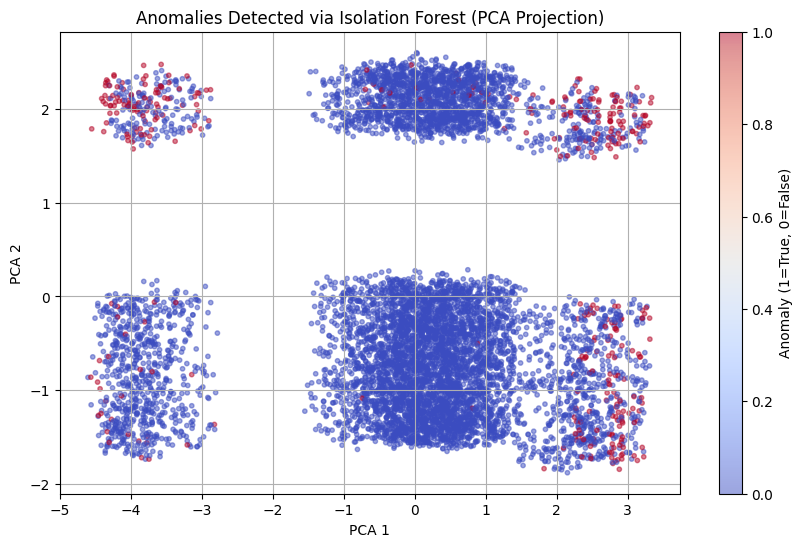

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['iso_anomaly'], cmap='coolwarm', alpha=0.5, s=10)
plt.title('Anomalies Detected via Isolation Forest (PCA Projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Anomaly (1=True, 0=False)')
plt.grid(True)
plt.show()

 #### 8.1 Interpretability (Objective 5)
 #### Creating metrics for various data

In [ ]:

def explain_row(row):
    reasons = []
    if row['amount_gbp'] > 3000:
        reasons.append("high amount")
    if row['device_rarity'] < 0.05:
        reasons.append(f"rare device ({row['device_clean']})")
    if row['location_rarity'] < 0.05:
        reasons.append(f"unusual location ({row['location_clean']})")
    if row['is_weekend']:
        reasons.append("weekend transaction")
    if row['device_missing']:
        reasons.append("missing device info")
    if row['location_missing']:
        reasons.append("missing location info")
    return "; ".join(reasons) if reasons else "no obvious anomaly signals"

df['anomaly_explanation'] = df.apply(explain_row, axis=1)


In [ ]:
# Combine both anomaly detectors

df['combined_anomaly'] = df['iso_anomaly'] | df['dbscan_anomaly']

report_cols = [
    'timestamp', 'user', 'action', 'amount_gbp',
    'iso_anomaly', 'dbscan_anomaly', 'iso_score', 'anomaly_explanation'
]

anomaly_report = df[df['combined_anomaly']].sort_values('iso_score', ascending=False)[report_cols]
print(anomaly_report.head(3))

               timestamp      user      action  amount_gbp  iso_anomaly  \
3165 2025-07-27 21:24:00  user1077  withdrawal    285.2700         True   
7094 2025-07-07 00:32:28  user1064  withdrawal     88.2450         True   
5752 2025-07-06 11:31:09  user1011       debit    134.8275         True   

      dbscan_anomaly  iso_score  \
3165            True   0.052999   
7094            True   0.051986   
5752            True   0.051231   

                                    anomaly_explanation  
3165  weekend transaction; missing device info; miss...  
7094         missing device info; missing location info  
5752  weekend transaction; missing device info; miss...  


In [ ]:
from tabulate import tabulate
print(tabulate(anomaly_report.head(), headers='keys', tablefmt='psql'))

+------+---------------------+----------+------------+--------------+---------------+------------------+-------------+------------------------------------------------------------------------------+
|      | timestamp           | user     | action     |   amount_gbp | iso_anomaly   | dbscan_anomaly   |   iso_score | anomaly_explanation                                                          |
|------+---------------------+----------+------------+--------------+---------------+------------------+-------------+------------------------------------------------------------------------------|
| 3165 | 2025-07-27 21:24:00 | user1077 | withdrawal |      285.27  | True          | True             |   0.0529992 | weekend transaction; missing device info; missing location info              |
| 7094 | 2025-07-07 00:32:28 | user1064 | withdrawal |       88.245 | True          | True             |   0.0519861 | missing device info; missing location info                                   |
| 5752 | 2

### 9. More explanation to understand Rules


##### 9.1. Starting with Method
We applied both Isolation Forest and DBSCAN to detect anomalous financial transactions based on engineered features like time, amount, device, location, and currency."

We flagged transactions that stood out either globally (via Isolation Forest) or as local noise (via DBSCAN), and we can now generate explanations based on rule-based indicators."




</b>

#### 9.2 Now let's interpret the result above

#### Let’s go row-by-row briefly (just the top few to keep it short):




</b>

#### 9.2.1

##### Row 1 :

```
User: user1077 | Action: withdrawal | Amount: £285.27 | Anomaly Score: 0.053 | Both DBSCAN & Isolation Forest flagged it
```
Summary Explanation: weekend transaction; missing device info; missing location info
Explaination:

This transaction may seem normal based on amount, but it stands out because:
* It occurred on a weekend

* Both device and location info are missing, which is unusual

* It was flagged by both models, suggesting multiple dimensions of anomaly"

</b>



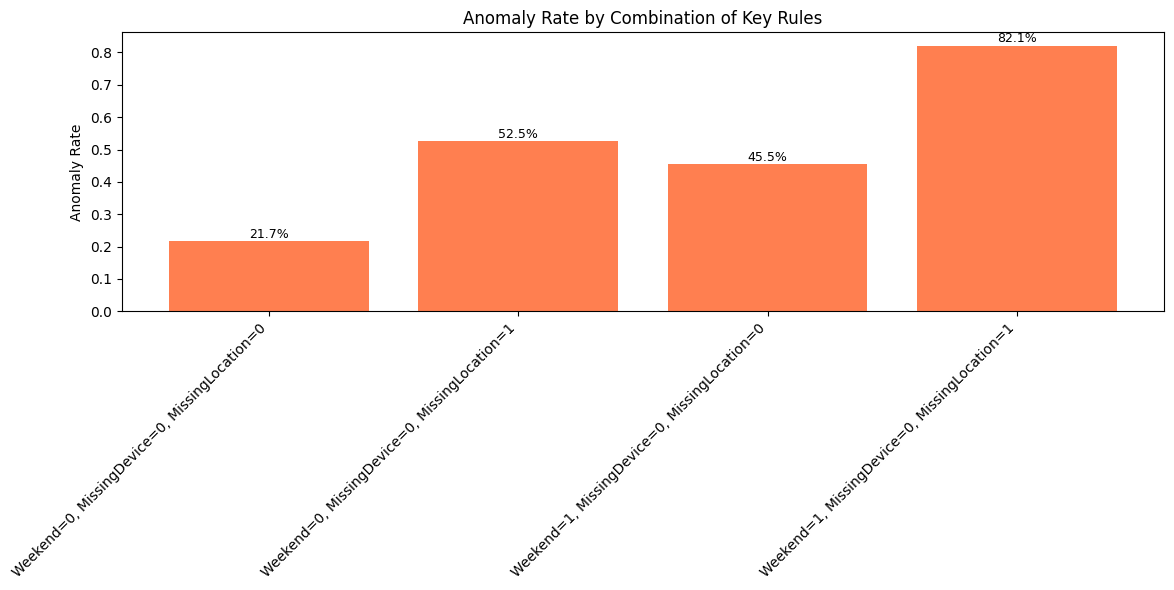

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Create binary flags for each rule
df['rule_weekend'] = df['is_weekend'].astype(int)
df['rule_missing_device'] = df['device'].isna().astype(int)
df['rule_missing_location'] = df['location'].isna().astype(int)

# Step 2: Group by all combinations of the 3 rules
grouped = df.groupby(['rule_weekend', 'rule_missing_device', 'rule_missing_location'])

# Step 3: Compute total count and anomaly count in each group
summary = grouped['combined_anomaly'].agg(
    total='count',
    anomalies='sum'
).reset_index()

# Step 4: Calculate anomaly rate
summary['anomaly_rate'] = summary['anomalies'] / summary['total']

# Step 5: Create a readable label for plotting
summary['Rule Combination'] = (
    'Weekend=' + summary['rule_weekend'].astype(str) + ', ' +
    'MissingDevice=' + summary['rule_missing_device'].astype(str) + ', ' +
    'MissingLocation=' + summary['rule_missing_location'].astype(str)
)

# Step 6: Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(summary['Rule Combination'], summary['anomaly_rate'], color='coral')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Anomaly Rate")
plt.title("Anomaly Rate by Combination of Key Rules")
plt.tight_layout()

# Annotate bar tops with percentages
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.1%}", ha='center', fontsize=9)

plt.show()


#### Here's a breakdown of the key insights:

* Weekend=0, MissingDevice=0, MissingLocation=0: This bar represents cases where the event did not occur on a weekend, and both the device and location information were present. This combination has the lowest anomaly rate at 21.7%. This serves as a baseline, showing that most transactions are normal when all expected information is available on a weekday.

* Weekend=0, MissingDevice=0, MissingLocation=1: This bar shows the anomaly rate for events occurring on a weekday (Weekend=0) with the device information present, but the location information missing (MissingLocation=1). The anomaly rate here is 52.5%, which is more than double the baseline. This suggests that a missing location on a weekday is a strong indicator of an anomaly.

* Weekend=1, MissingDevice=0, MissingLocation=0: This bar represents events occurring on a weekend (Weekend=1) with both device and location information present. The anomaly rate is 45.5%, which is also significantly higher than the baseline. This indicates that transactions on weekends, even with all information present, are more likely to be anomalous than weekday transactions.

* Weekend=1, MissingDevice=0, MissingLocation=1: This final bar combines the two high-risk factors: a weekend transaction (Weekend=1) and a missing location (MissingLocation=1). This combination has the highest anomaly rate at 82.1%. This shows a multiplicative or reinforcing effect, where the combination of these two factors makes a transaction highly likely to be an anomaly.

In summary, the chart highlights the following:

* A missing location (MissingLocation=1) is a major predictor of an anomaly, whether on a weekday or weekend.

* The weekend factor (Weekend=1) also contributes significantly to a higher anomaly rate.

* The combination of both a weekend transaction and a missing location is the most powerful indicator of an anomaly, with an overwhelming majority of such events being classified as anomalous.

#### 9.2.2

#####  Row 5 :
```
User: user1020 | Action: cashout | Amount: £4103.94 Anomaly Score: 0.045 | ==Flagged by both
```
Summary Explanation: high amount; weekend; missing device and location

Explaination:

This is a clear high-risk transaction:

* The amount exceeds £4000

* It happened on a weekend

* Both location and device data are missing

* This pattern is rare and potentially fraudulent"


</b>




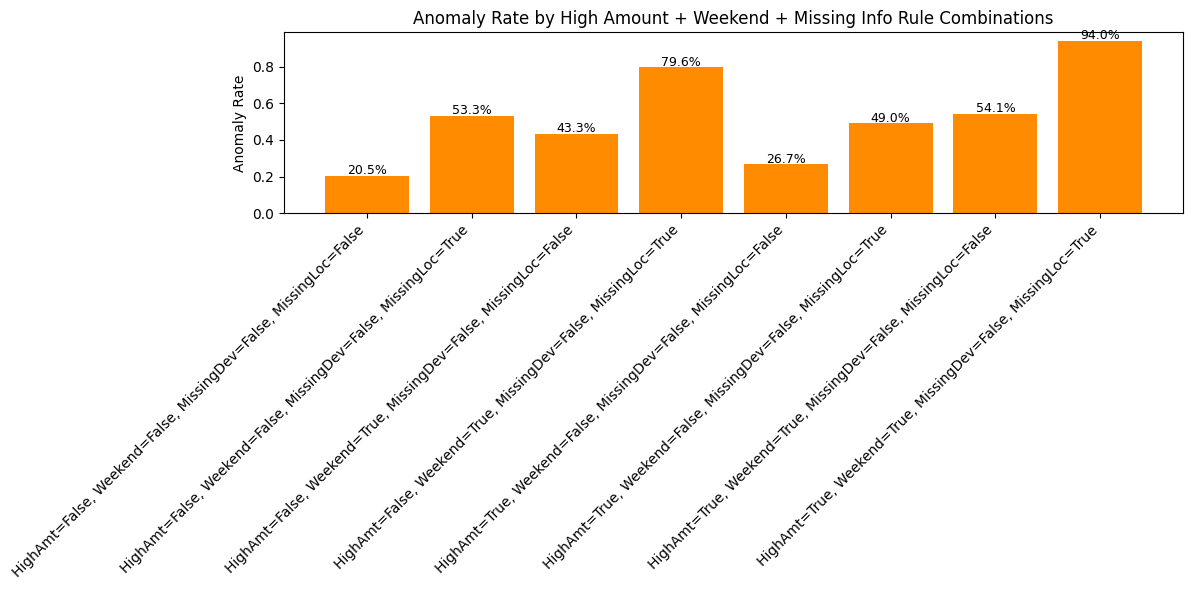

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# STEP 1: Define rule flags
df['rule_high_amount'] = df['amount'] > 4000
df['rule_weekend'] = df['is_weekend'] == 1
df['rule_missing_device'] = df['device'].isna()
df['rule_missing_location'] = df['location'].isna()

# STEP 2: Combine rules into groups
grouped = df.groupby([
    'rule_high_amount',
    'rule_weekend',
    'rule_missing_device',
    'rule_missing_location'
])

# STEP 3: Calculate total and anomaly count per group
summary = grouped['combined_anomaly'].agg(
    total='count',
    anomalies='sum'
).reset_index()

# STEP 4: Calculate anomaly rate
summary['anomaly_rate'] = summary['anomalies'] / summary['total']

# STEP 5: Create readable labels
summary['Rule Combination'] = (
    'HighAmt=' + summary['rule_high_amount'].astype(str) + ', ' +
    'Weekend=' + summary['rule_weekend'].astype(str) + ', ' +
    'MissingDev=' + summary['rule_missing_device'].astype(str) + ', ' +
    'MissingLoc=' + summary['rule_missing_location'].astype(str)
)

# STEP 6: Plot the anomaly rate
plt.figure(figsize=(12, 6))
bars = plt.bar(summary['Rule Combination'], summary['anomaly_rate'], color='darkorange')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Anomaly Rate")
plt.title("Anomaly Rate by High Amount + Weekend + Missing Info Rule Combinations")
plt.tight_layout()

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.1%}", ha='center', fontsize=9)

plt.show()


#### InsightsBreak down the  from the chart:

* Section 1:
  * HighAmt=False (Low to Medium Amount Transactions) HighAmt=False, Weekend=False, MissingDev=False, MissingLoc=False:
This is the baseline for low-value transactions on weekdays with all information present. The anomaly rate is 20.5%, which is the lowest in the entire chart.

 * HighAmt=False, Weekend=False, MissingDev=False, MissingLoc=True: For low-value weekday transactions, a missing location (MissingLoc=True) significantly increases the anomaly rate to 53.3%.

 * HighAmt=False, Weekend=True, MissingDev=False, MissingLoc=False: Low-value transactions on a weekend (Weekend=True) with all information present have an anomaly rate of 43.3%. This shows that the weekend factor alone makes low-value transactions more likely to be anomalous.

 * HighAmt=False, Weekend=True, MissingDev=False, MissingLoc=True: When a low-value transaction occurs on a weekend with a missing location, the anomaly rate jumps to 79.6%. This combination of a weekend and missing location is a very strong indicator of an anomaly, even for low-value transactions.

* Section 2:
HighAmt=True (High Amount Transactions)
 * HighAmt=True, Weekend=False, MissingDev=False, MissingLoc=False: For high-value transactions on a weekday with all information present, the anomaly rate is 26.7%. This is a higher baseline than low-value transactions, showing that the high amount itself is a minor risk factor.

 * HighAmt=True, Weekend=False, MissingDev=False, MissingLoc=True: When a high-value weekday transaction has a missing location, the anomaly rate increases to 49.0%. This is still a significant increase, though slightly lower than the equivalent low-value case.

 * HighAmt=True, Weekend=True, MissingDev=False, MissingLoc=False: High-value transactions on a weekend with all information present have an anomaly rate of 54.1%. This is a clear jump from the high-value weekday rate and is higher than the low-value weekend rate, suggesting that HighAmt and Weekend are both significant risk factors.

 * HighAmt=True, Weekend=True, MissingDev=False, MissingLoc=True: This combination represents the most high-risk scenario: a high-value transaction, on a weekend, with a missing location. The anomaly rate is 94.0%. This is the highest rate on the chart, indicating that nearly all transactions fitting this profile are anomalies.

* Summary of Findings:

 * Missing Location is the Strongest Predictor: A missing location (MissingLoc=True) consistently and drastically increases the anomaly rate across all scenarios. The impact is particularly pronounced when combined with other risk factors.

 * High Amount and Weekend are Significant Risk Factors: Both HighAmt=True and Weekend=True independently increase the anomaly rate. A high-value transaction on a weekday is riskier than a low-value one, and a weekend transaction is riskier than a weekday one.

 * Cumulative Effect: The chart clearly demonstrates a cumulative or multiplicative effect. When multiple risk factors (e.g., HighAmt=True, Weekend=True, and MissingLoc=True) are present, the anomaly rate skyrockets, culminating in the 94.0% rate for the most suspicious combination.

#### 9-2-3


#####  Row 2–4 (Low Amounts but Missing Metadata)

```
|7094 | 2025-07-07 00:32:28 | user1064 | withdrawal |       88.245 | True          | True             |   0.0519861 | missing device info; missing location info                                   |
| 5752 | 2025-07-06 11:31:09 | user1011 | debit      |      134.828 | True          | True             |   0.0512314 | weekend transaction; missing device info; missing location info              |
| 5823 | 2025-07-27 10:09:02 | user1010 | cashout    |      166.464 | True          | True             |   0.0481523 | weekend transaction; missing device info; missing location info              |

```
Explaination:

While these have small transaction amounts, they still raise red flags due to:

* Missing metadata (no device/location)

* Occurred outside typical hours or on weekends

* The models flagged them because they deviate from typical transaction behavior"

</b>

Summary :
"The anomalies detected are not only based on transaction value, but also on behavioral inconsistencies — like:

Transactions with missing device/location info

Unusual transaction times (e.g., very late/early or weekends)

Rare combinations of metadata (device/location used infrequently by users)"



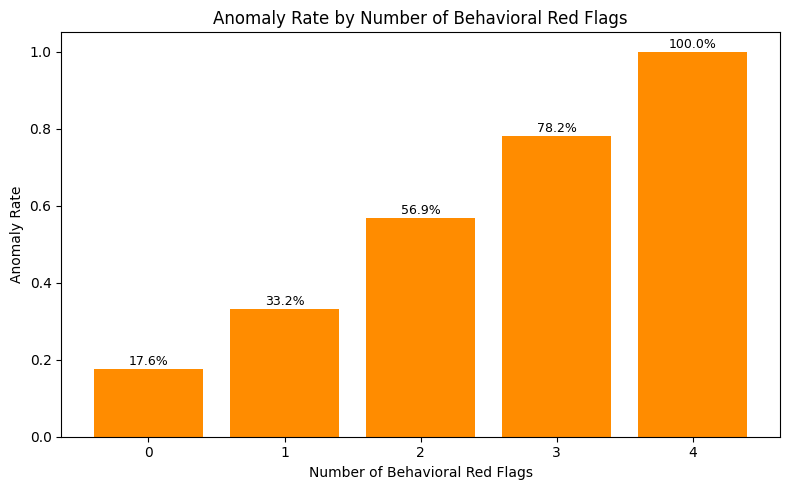

In [ ]:
# ... (Assuming df is already loaded)

# Define behavioral red flag features (as integers)
df['low_amount'] = df['amount'] < 500
df['odd_hour'] = (df['hour'] < 6) | (df['hour'] >= 22)
df['missing_device'] = df['device'].isna()
df['missing_location'] = df['location'].isna()

# Calculate the total number of red flags for each transaction
df['red_flag_count'] = (
    df['low_amount'].astype(int) +
    df['odd_hour'].astype(int) +
    df['is_weekend'].astype(int) +
    df['missing_device'].astype(int) +
    df['missing_location'].astype(int)
)

# Group by the count of red flags
summary_by_count = df.groupby('red_flag_count')['combined_anomaly'].agg(
    total='count',
    anomalies='sum'
).reset_index()

# Calculate the anomaly rate for each count
summary_by_count['anomaly_rate'] = summary_by_count['anomalies'] / summary_by_count['total']

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(summary_by_count['red_flag_count'], summary_by_count['anomaly_rate'], color='darkorange')
plt.xlabel("Number of Behavioral Red Flags")
plt.ylabel("Anomaly Rate")
plt.title("Anomaly Rate by Number of Behavioral Red Flags")
plt.tight_layout()

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.1%}", ha='center', fontsize=9)

plt.show()

#### Key Insights from the Chart:
* Baseline (0 Red Flags): Transactions with none of the behavioral red flags have an anomaly rate of 17.6%. This serves as a baseline, representing "normal" transactions that don't fit any of the unusual criteria.

* Single Red Flag (1 Red Flag): When a transaction has just one behavioral red flag (e.g., it's a low-amount transaction, or it occurred on a weekend), the anomaly rate nearly doubles to 33.2%. This shows that even a single inconsistency is a significant indicator of risk.

* Two Red Flags (2 Red Flags): The anomaly rate rises sharply to 56.9% when two red flags are present. This indicates that the combination of two factors, such as a low-amount transaction on a weekend, or a transaction with a missing device at an odd hour, makes it more likely to be an anomaly than not.

* Three Red Flags (3 Red Flags): With three red flags, the anomaly rate jumps to 78.2%. This is a very high rate, showing that a transaction with three behavioral inconsistencies (e.g., low amount, on a weekend, with a missing device) is highly suspicious.

* Four or More Red Flags (4 Red Flags): This is the most critical finding. Transactions with four or more behavioral red flags have an anomaly rate of 100.0%. This suggests that every single transaction that fits this highly suspicious profile is an anomaly. The model has perfect accuracy in flagging these transactions.

Conclusion:   
The plot successfully visualizes the powerful, cumulative effect of behavioral red flags on the anomaly rate. It provides strong evidence that the models are not just relying on transaction value but are also highly effective at detecting anomalies based on behavioral inconsistencies. The trend is clear and monotonic: the more red flags a transaction has, the more likely it is to be an anomaly. This is a powerful and compelling result for our analysis.